In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  RBF


import Bgolearn.BGOsampling as BGOS 

 Bgolearn : A Bayesian global optimization package 
 10 Jul 2022, version 1, Bin Cao, MGI, SHU, Shanghai, CHINA.


In [2]:
def True_function(X):
    X = np.array(X)
    Y = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8
    return Y

In [3]:
def generate_function(data, obs):
    print('------------12 original data-----------')
    data = np.array(data)
    # for one feature dataset
    data_matrix = np.array(data[:,0]).reshape(-1, 1)

    Measured_response = np.zeros(len(data_matrix))
    for i in range(obs):
        Measured_response += np.array(data[:,i+1])
    # for one feature dataset
    Measured_response = Measured_response/obs
    
    Measured_std = []
    for j in range(len(data_matrix)):
        std = np.std(np.array(data[j,1:1+obs]))
        Measured_std.append(std)
    Measured_std = np.array(Measured_std)  
    print('evaluated mean of y :', Measured_response)
    print('evaluated std of y :', Measured_std)
    print('---------------------------------------\n')
    return data_matrix,Measured_response,Measured_std

## design virtual samples

In [4]:
virtual_samples = np.linspace(0,11,100)

## define a callable Kriging model and sampling function

In [5]:
def Sam_function(X,real_std,obs):
    print('--------------Draw samples-------------')
    print('real std of added datum:', real_std)
    X = np.array(X)
    Y = np.zeros(1)
    Y_list = []
    for i in range(obs):
        __sam = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8 + np.random.normal(loc=0.0, scale=real_std, size=None)
        Y_list.append(__sam)
        Y += __sam
        print(i+1,'-th sampling, result = ', __sam)
    cal_std = np.std(np.array(Y_list))
    print('evaluated mean of added datum:', Y/obs)
    print('evaluated std of added datum:', cal_std)
    print('---------------------------------------\n')
    return Y/obs, np.array(cal_std)


## instantiate Bgolearn

In [6]:
Bgolearn = BGOS.Bgolearn()
method_name = 'KG'


------------12 original data-----------
evaluated mean of y : [6.21494888 5.56581958 4.61988109 4.34056442 4.35646479 4.67190767
 4.62173112 4.55605355 4.70138419 4.48867457 5.8769712  7.75473896]
evaluated std of y : [0.30008321 0.2742029  0.07394358 0.91538122 0.33136727 0.29720623
 0.07801782 0.48293232 0.24548787 0.12272781 0.21645983 0.25832216]
---------------------------------------

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [7.88888889]
--------------Draw samples-------------
real std of added datum: 0.2
1 -th sampling, result =  3.0750556036217187
2 -th sampling, result =  2.899715991651823
3 -th sampling, result =  3.391074639398785
evaluated mean of added datum: [3.12194874]
evaluated std of added datum: 0.2033183959581468
---------------------------------------

1-th iteration 
 new added datum: [7.9, array([3.1219])]


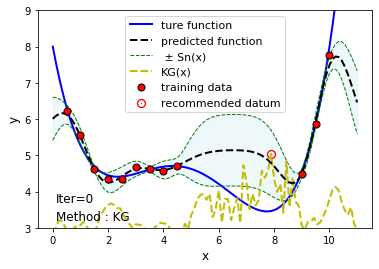

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [7.22222222]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.7176829243986047
2 -th sampling, result =  3.791676897437358
3 -th sampling, result =  3.2678175938540703
evaluated mean of added datum: [3.59239247]
evaluated std of added datum: 0.2314885391026159
---------------------------------------

2-th iteration 
 new added datum: [7.2, array([3.5924])]


<Figure size 432x288 with 0 Axes>

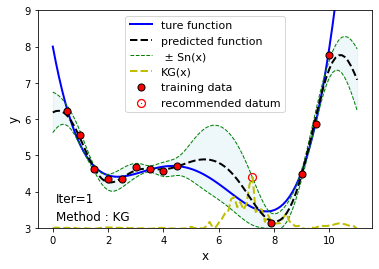

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [6.11111111]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  4.448340946528261
2 -th sampling, result =  4.331007844281072
3 -th sampling, result =  3.7255794271925247
evaluated mean of added datum: [4.16830941]
evaluated std of added datum: 0.31670084709106716
---------------------------------------

3-th iteration 
 new added datum: [6.1, array([4.1683])]


<Figure size 432x288 with 0 Axes>

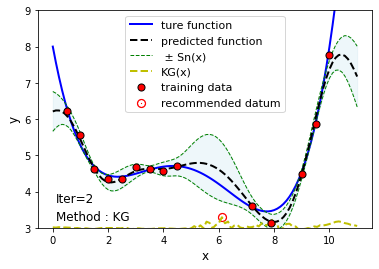

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [7.66666667]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.274172668132462
2 -th sampling, result =  3.563886909616524
3 -th sampling, result =  3.66324579921294
evaluated mean of added datum: [3.50043513]
evaluated std of added datum: 0.16505367207510455
---------------------------------------

4-th iteration 
 new added datum: [7.7, array([3.5004])]


<Figure size 432x288 with 0 Axes>

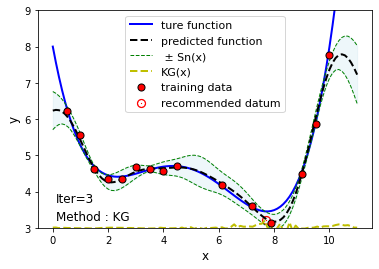

<Figure size 432x288 with 0 Axes>

In [9]:
obs = 3

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            if len(xtrain) != len(Measured_std):
                new_alpha = np.append(Measured_std,0.2)
                mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = new_alpha**2).fit(xtrain,ytrain)
            else:
                mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = Measured_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.Knowledge_G()*10 + 3
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))

    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-obs_{obstime}-{num}.png'.format(name = method_name,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break

------------12 original data-----------
evaluated mean of y : [6.29185161 5.39856881 4.62623151 4.38385368 4.46148423 4.63694734
 4.5905237  4.59016103 4.67177078 4.4811777  5.95522378 7.80150911]
evaluated std of y : [0.29202661 0.37457828 0.06497479 0.79628133 0.33976528 0.26441507
 0.08652626 0.42238334 0.21869861 0.10707566 0.23132562 0.23792876]
---------------------------------------

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [8.33333333]
--------------Draw samples-------------
real std of added datum: 0.2
1 -th sampling, result =  3.6547565752523807
2 -th sampling, result =  3.4043205893577246
3 -th sampling, result =  3.7785975999208428
4 -th sampling, result =  3.599412495285232
evaluated mean of added datum: [3.60927181]
evaluated std of added datum: 0.13494655972993988
---------------------------------------

1-th iteration 
 new added datum: [8.3, array([3.6093])]


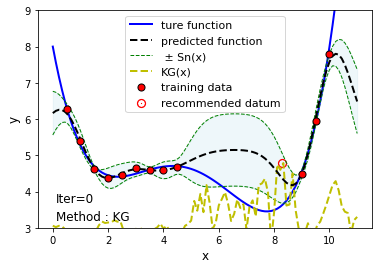

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [6.88888889]
--------------Draw samples-------------
real std of added datum: 0.5
1 -th sampling, result =  3.8539090945924435
2 -th sampling, result =  2.878352685137239
3 -th sampling, result =  3.4820208487788813
4 -th sampling, result =  3.9216869843511635
evaluated mean of added datum: [3.5339924]
evaluated std of added datum: 0.4138895565413037
---------------------------------------

2-th iteration 
 new added datum: [6.9, array([3.534])]


<Figure size 432x288 with 0 Axes>

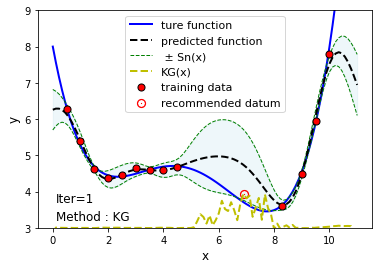

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [7.33333333]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.2065254646506034
2 -th sampling, result =  3.438698518551415
3 -th sampling, result =  3.244966957736458
4 -th sampling, result =  3.3819884586580504
evaluated mean of added datum: [3.31804485]
evaluated std of added datum: 0.09542411182389612
---------------------------------------

3-th iteration 
 new added datum: [7.3, array([3.318])]


<Figure size 432x288 with 0 Axes>

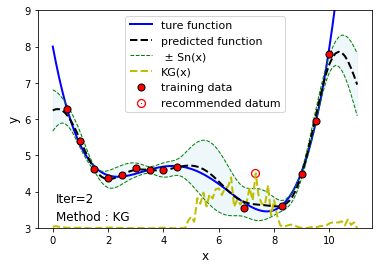

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [6.33333333]
--------------Draw samples-------------
real std of added datum: 0.4
1 -th sampling, result =  4.389223726107075
2 -th sampling, result =  3.8690466435776623
3 -th sampling, result =  4.209471064500042
4 -th sampling, result =  3.9865106036724605
evaluated mean of added datum: [4.11356301]
evaluated std of added datum: 0.20069737960711506
---------------------------------------

4-th iteration 
 new added datum: [6.3, array([4.1136])]


<Figure size 432x288 with 0 Axes>

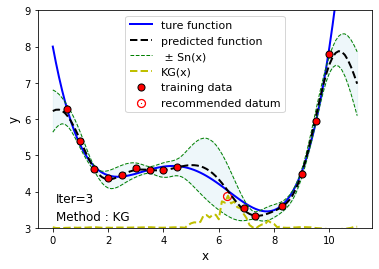

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [8.]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  2.8638531736964157
2 -th sampling, result =  3.186985444136983
3 -th sampling, result =  3.2290682449367196
4 -th sampling, result =  2.72530224060081
evaluated mean of added datum: [3.00130228]
evaluated std of added datum: 0.21296939381017005
---------------------------------------

5-th iteration 
 new added datum: [8.0, array([3.0013])]


<Figure size 432x288 with 0 Axes>

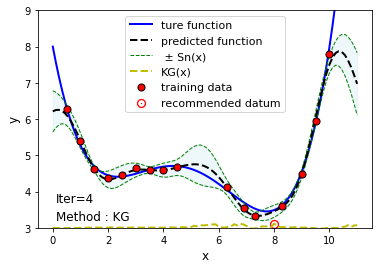

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [10.66666667]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  13.126053023457322
2 -th sampling, result =  12.32470253631251
3 -th sampling, result =  12.169202152929271
4 -th sampling, result =  12.48768325760799
evaluated mean of added datum: [12.52691024]
evaluated std of added datum: 0.3637835421314915
---------------------------------------

6-th iteration 
 new added datum: [10.7, array([12.5269])]


<Figure size 432x288 with 0 Axes>

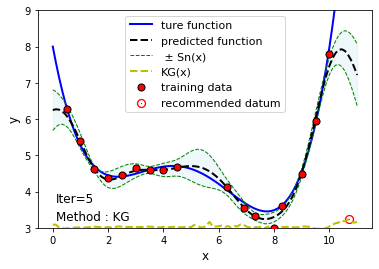

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [11.]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  14.3792273265149
2 -th sampling, result =  15.134537736821825
3 -th sampling, result =  15.36230734434344
4 -th sampling, result =  15.488606924841479
evaluated mean of added datum: [15.09116983]
evaluated std of added datum: 0.43017865464569227
---------------------------------------

7-th iteration 
 new added datum: [11.0, array([15.0912])]


<Figure size 432x288 with 0 Axes>

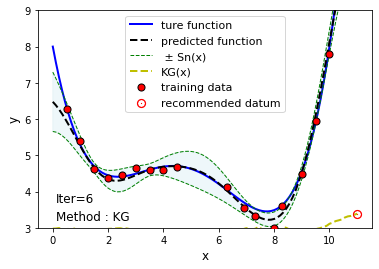

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [11.]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  14.74061949503277
2 -th sampling, result =  13.240544644353228
3 -th sampling, result =  15.053217014869363
4 -th sampling, result =  16.089472240484724
evaluated mean of added datum: [14.78096335]
evaluated std of added datum: 1.019906244447554
---------------------------------------

8-th iteration 
 new added datum: [11.0, array([14.781])]


<Figure size 432x288 with 0 Axes>

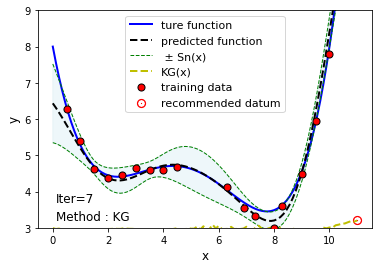

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [11.]
--------------Draw samples-------------
real std of added datum: 0.4
1 -th sampling, result =  15.403928375902188
2 -th sampling, result =  15.102227572390362
3 -th sampling, result =  15.599303810322354
4 -th sampling, result =  14.424675707794892
evaluated mean of added datum: [15.13253387]
evaluated std of added datum: 0.44539611709623833
---------------------------------------

9-th iteration 
 new added datum: [11.0, array([15.1325])]


<Figure size 432x288 with 0 Axes>

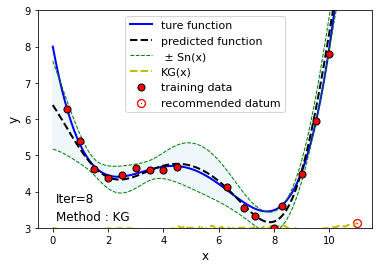

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [5.]
--------------Draw samples-------------
real std of added datum: 0.1
1 -th sampling, result =  4.49350638842321
2 -th sampling, result =  4.521046368772991
3 -th sampling, result =  4.585178060444469
4 -th sampling, result =  4.579273781533666
evaluated mean of added datum: [4.54475115]
evaluated std of added datum: 0.03877528019942857
---------------------------------------

10-th iteration 
 new added datum: [5.0, array([4.5448])]


<Figure size 432x288 with 0 Axes>

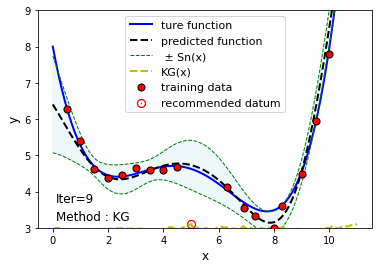

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [7.11111111]
--------------Draw samples-------------
real std of added datum: 0.2
1 -th sampling, result =  4.018061965376766
2 -th sampling, result =  3.835559577479586
3 -th sampling, result =  3.2991931134116834
4 -th sampling, result =  3.3579571948650258
evaluated mean of added datum: [3.62769296]
evaluated std of added datum: 0.306702634168158
---------------------------------------

11-th iteration 
 new added datum: [7.1, array([3.6277])]


<Figure size 432x288 with 0 Axes>

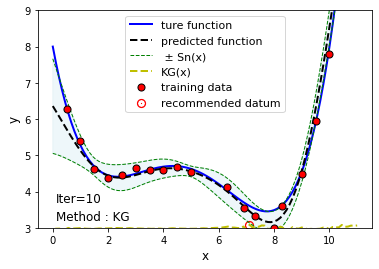

Searching is defeated


<Figure size 432x288 with 0 Axes>

In [10]:
obs = 4

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            if len(xtrain) != len(Measured_std):
                new_alpha = np.append(Measured_std,0.2)
                mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = new_alpha**2).fit(xtrain,ytrain)
            else:
                mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = Measured_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.Knowledge_G()*10 + 3
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))

    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-obs_{obstime}-{num}.png'.format(name = method_name,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break

------------12 original data-----------
evaluated mean of y : [6.38302126 5.47159103 4.62333861 4.45561327 4.45288222 4.66633633
 4.60958967 4.62022357 4.74050698 4.45448135 5.94232697 7.79008494]
evaluated std of y : [0.31854553 0.36548063 0.05840252 0.72653212 0.30438189 0.24369472
 0.0862756  0.38254565 0.23908561 0.10964916 0.20850551 0.21403299]
---------------------------------------

The 2000-th Monte carlo simulation
The 4000-th Monte carlo simulation
The next datum recomended by Knowledge Gradient : 
 x =  [7.66666667]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.0072728505875057
2 -th sampling, result =  3.6974198990428464
3 -th sampling, result =  3.555785777301868
4 -th sampling, result =  3.2400859152356003
5 -th sampling, result =  4.036391716042484
evaluated mean of added datum: [3.50739123]
evaluated std of added datum: 0.3577331313220533
---------------------------------------

1-th iteration 
 new added datum: [7.7, 

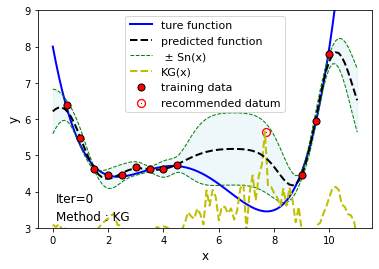

<Figure size 432x288 with 0 Axes>

In [8]:
obs = 5

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            if len(xtrain) != len(Measured_std):
                new_alpha = np.append(Measured_std,0.2)
                mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = new_alpha**2).fit(xtrain,ytrain)
            else:
                mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = Measured_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.Knowledge_G()*10 + 3
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))

    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-obs_{obstime}-{num}.png'.format(name = method_name,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break